# Quora Question-pair classification


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy

from collections import Counter
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,precision_recall_curve

In [19]:
### Load spaCy's English NLP model
nlp = spacy.load('en_core_web_lg')

## 1. Read train csv file

In [4]:
%%time
print('Time taken to read the train data:')
train = pd.read_csv("train.csv").fillna("")

Time taken to read the train data:
Wall time: 4.61 s


In [37]:
train.head() 

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [38]:
%%time
print('Time taken to read the test data:')
test = pd.read_csv("test.csv", low_memory=False).fillna("")

Time taken to read the test data:
Wall time: 37.8 s


In [39]:
test.head() 

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [56]:
df_train = pd.read_csv("train.csv", nrows=1000)

## 2. Exploratory Data Analysis

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404290 non-null object
question2       404290 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [19]:
train.shape

(404290, 6)

In [20]:
"""Check for missing values:"""
print(train['question1'].str.isspace().sum())
print(train['question2'].str.isspace().sum())

0
0


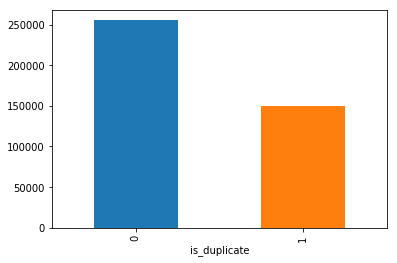

In [21]:
train.groupby("is_duplicate")['id'].count().plot.bar()

In [22]:
train.groupby("is_duplicate")['id'].count()

is_duplicate
0    255027
1    149263
Name: id, dtype: int64

## 3. Preprocessing

## Remove stop words and lemmatize (converting a word to its base form)

In [12]:
from nltk.corpus import stopwords
stops = set(stopwords.words("english"))

In [13]:
def normalize(text, lowercase, remove_stopwords):
    if lowercase:
        text = text.lower()
    text = nlp(text)
    lemmatized = list()
    for word in text:
        lemma = word.lemma_.strip()
        if lemma:
            if not remove_stopwords or (remove_stopwords and lemma not in stops):
                lemmatized.append(lemma)
    return " ".join(lemmatized)

In [57]:
df_train['Q1_After_Clean'] = df_train['question1'].apply(normalize, lowercase=True, remove_stopwords=True)

In [58]:
df_train['Q2_After_Clean'] = df_train['question2'].apply(normalize, lowercase=True, remove_stopwords=True)

## Feature Construction

In [59]:
df_train['q1len'] = df_train['question1'].str.len()
df_train['q2len'] = df_train['question2'].str.len()

df_train['q1_n_words'] = df_train['question1'].apply(lambda row: len(row.split(" ")))
df_train['q2_n_words'] = df_train['question2'].apply(lambda row: len(row.split(" ")))
df_train['q_n_words_avg'] = np.round((df_train['q1_n_words'] + df_train['q2_n_words'])/2.0).astype(int)


def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))

def jaccard_similarity_score(text1, text2):
    "Computes Jaccard similarity score between text1 and text2"
    intersection = len(set(text1) & set(text2))
    union = len(set(text1) | set(text2))
    if len(text1) == 0 or len(text2) == 0:
        return 0
    score = float(intersection)/float(union)
    return score

df_train['word_share'] = df_train.apply(normalized_word_share, axis=1)

Jaccard_score = []
for index, row in df_train.iterrows():
    score = jaccard_similarity_score(row['Q1_After_Clean'], row['Q2_After_Clean'])
    Jaccard_score.append(score)
df_train['Jaccard_score'] = Jaccard_score

In [60]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate,Q1_After_Clean,Q2_After_Clean,q1len,q2len,q1_n_words,q2_n_words,q_n_words_avg,word_share,Jaccard_score
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,step step guide invest share market india ?,step step guide invest share market ?,66,57,14,12,13,0.434783,1.000000
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,story kohinoor ( koh - - noor ) diamond ?,would happen indian government steal kohinoor ...,51,88,8,13,10,0.200000,0.615385
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,increase speed -PRON- internet connection use ...,internet speed increase hack dns ?,73,59,14,10,12,0.166667,0.545455
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,mentally lonely ? solve -PRON- ?,find remainder [ math]23^{24}[/math ] divide 2...,50,65,11,9,10,0.000000,0.250000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"one dissolve water quikly sugar , salt , metha...",fish would survive salt water ?,76,39,13,7,10,0.100000,0.576923


In [61]:
df_train.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'Q1_After_Clean', 'Q2_After_Clean', 'q1len', 'q2len', 'q1_n_words',
       'q2_n_words', 'q_n_words_avg', 'word_share', 'Jaccard_score'],
      dtype='object')

In [63]:
from sklearn.preprocessing import MinMaxScaler
X = MinMaxScaler().fit_transform(df_train[['q1len','q2len','q1_n_words','q2_n_words','word_share','q_n_words_avg','Jaccard_score']])
y = df_train['is_duplicate'].values

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

## Gradient Boosting Classifier

In [26]:
# Import the model we are using
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators':np.arange(10,61,10),'max_depth':np.arange(2,10,2),'learning_rate':[0.01,0.1,0.5,0.9]}
model=GradientBoostingClassifier(min_samples_split=500,min_samples_leaf=50,subsample=0.8,random_state=42,loss = 'deviance')

evaluation_metric = ['r2','neg_mean_squared_error']
for i in evaluation_metric:
    gsearch1 = GridSearchCV(model,parameters,scoring=i,cv=None) 
    gsearch1.fit(X_train,y_train)
    print("Best param for",i,"are: ",gsearch1.best_params_)
    print("Best score for",i,"are: ",gsearch1.best_score_)

Best param for r2 are:  {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 10}
Best score for r2 are:  -0.6013205282112846
Best param for neg_mean_squared_error are:  {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 10}
Best score for neg_mean_squared_error are:  -0.37551020408163266


## Evaluation of Gradient Boosting Classifier

In [28]:
from sklearn.metrics import mean_squared_error, r2_score,explained_variance_score

# Instantiate the GradientBoostingClassifier model with best parameters
model = GradientBoostingClassifier(learning_rate=0.01, max_depth=2, n_estimators=10, min_samples_split=500,min_samples_leaf=50,max_features='sqrt',subsample=0.8,loss = 'deviance',random_state=42)

#Train the model using the training sets
model.fit(X_train,y_train)

# Make Predictions on Train set
y_train_pred = model.predict(X_train)
print('Mean Square Error on train dataset :',mean_squared_error(y_train, y_train_pred))
print('R2 on train dataset :',r2_score(y_train, y_train_pred))
print('Explained variance score on train dataset :',explained_variance_score(y_train, y_train_pred))

# Make Predictions on Test set
y_test_pred = model.predict(X_test)
print('Mean Square Error on test dataset :',mean_squared_error(y_test, y_test_pred))
print('R2 on train dataset :',r2_score(y_test, y_test_pred))
print('Explained variance score on train dataset :',explained_variance_score(y_test, y_test_pred))

Mean Square Error on train dataset : 0.37551020408163266
R2 on train dataset : -0.6013071895424835
Explained variance score on train dataset : 0.0
Mean Square Error on test dataset : 0.40476190476190477
R2 on train dataset : -0.6799999999999999
Explained variance score on train dataset : 0.0


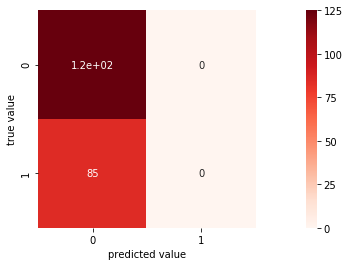

In [30]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve,auc
mat = confusion_matrix(y_test,y_test_pred)
plt.subplots(figsize = (18,4))
sns.heatmap(mat, square=True, annot=True, cbar=True , cmap = 'Reds')
plt.xlabel('predicted value')
plt.ylabel('true value');


In [31]:
print(classification_report(y_test,y_test_pred))

C:\Users\pooja\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.60      1.00      0.75       125
          1       0.00      0.00      0.00        85

avg / total       0.35      0.60      0.44       210



## Precision Recall Plot

Average precision-recall score: 0.40


Text(0.5,1,'2-class Precision-Recall curve: AP=0.40')

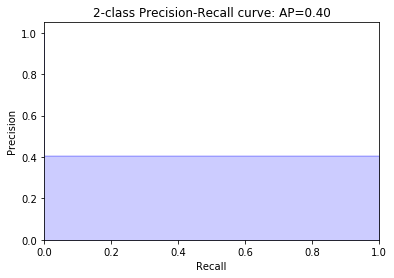

In [33]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_test_pred)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))


from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

precision, recall, _ = precision_recall_curve(y_test, y_test_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))